In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import scipy as sp

In [2]:
root_path = "results/"

In [3]:
import glob
import pandas as pd
dataset = "MovieLens1M"
results_files_list = glob.glob(f"{root_path}/{dataset}/*.csv")

In [4]:
all_dfs = []

for result_file in results_files_list:
    result_df = pd.read_csv(result_file)
    all_dfs.append(result_df)

# concat all of the dataframes
results_df = pd.concat(all_dfs)

In [5]:
# print in latex format to put in the paper
# for eachline in results_df.itertuples(index=True):
  # print(f"{eachline.Model} & {eachline.Type} & {eachline.ndcg_ALL} & {eachline.CatCov_ALL} & {eachline.avg_JSH_all} & {eachline.avg_Hell_all} \\\\")

### Barplot Test vs. Train

In [ ]:
# set width of bar
barWidth = 0.20
# fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
JS = [0.07533822069457305, 0.2603085308559478, 0.4052769551083986]
Hell = [0.07875051012779152, 0.2919298883264158, 0.4679492188200486]
 
# Set position of bar on X axis
br1 = np.arange(len(JS))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, JS, width = barWidth, label ='Jensen–Shannon (JS)')
plt.bar(br2, Hell, width = barWidth, label ='Hellinger (H)')
 
# Adding Xticks
plt.xlabel('User Groups', fontsize = 15)
plt.ylabel('Values', fontsize = 15)
plt.xticks([r + 0.1 for r in range(len(JS))], ['Active', 'Semi-active', 'Inactive'])
 
plt.legend()
plt.savefig(f'plots/{dataset}/testvstrain_{dataset}.pdf', bbox_inches='tight')

### Heatmap for User Groups on CatCoverage

In [16]:
heatmap_df = pd.DataFrame(columns=['Model', 'Type', 'UserGroup', 'CatCov', 'JS'])

for eachline in results_df.itertuples(index=True):
  if eachline.Model not in ['MostPop', 'ItemKNN-Cosine', 'UserKNN-BM25']:
    if eachline.Type in ['CL', 'CCL']:
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Active', 'CatCov': eachline.CatCov_POP, 'JS': eachline.avg_JSH_pop}, ignore_index=True)
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Semi-active', 'CatCov': eachline.CatCov_DIV, 'JS': eachline.avg_JSH_div}, ignore_index=True)
      heatmap_df = heatmap_df.append({'Model': eachline.Model,'Type': eachline.Type, 'UserGroup': 'Inactive', 'CatCov': eachline.CatCov_UNPOP, 'JS': eachline.avg_JSH_unpop}, ignore_index=True)

In [17]:
# group heatmap dataframe by model
group_heatmap_df = heatmap_df.groupby('UserGroup')

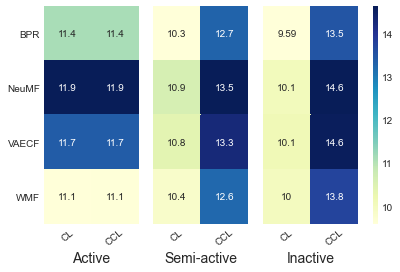

In [18]:
# generating heatmap for original and fair on UGF of Precision

df_Pop = group_heatmap_df.get_group('Active').pivot("Model", "Type", "CatCov")
df_Div = group_heatmap_df.get_group('Semi-active').pivot("Model", "Type", "CatCov")
df_UnPop = group_heatmap_df.get_group('Inactive').pivot("Model", "Type", "CatCov")

f, (ax0,ax1,ax2,axcb) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 1, 1, 0.06]}, figsize=(6, 4))

g0 = sns.heatmap(data=df_Pop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('Active', fontsize=14)

g1 = sns.heatmap(data=df_Div.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Semi-active', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_UnPop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('Inactive', fontsize=14)
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=40)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.savefig(f'plots/{dataset}/heatmap_CatCov_{dataset}.pdf', bbox_inches='tight')

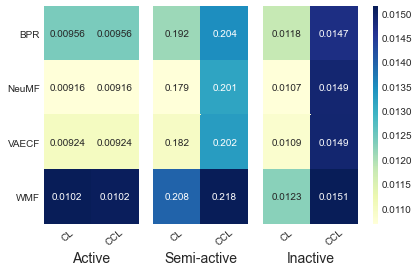

In [23]:
# generating heatmap for original and fair on UGF of Precision

df_Pop = group_heatmap_df.get_group('Active').pivot("Model", "Type", "JS")
df_Div = group_heatmap_df.get_group('Semi-active').pivot("Model", "Type", "JS")
df_UnPop = group_heatmap_df.get_group('Inactive').pivot("Model", "Type", "JS")

f, (ax0,ax1,ax2,axcb) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 1, 1, 0.06]}, figsize=(6, 4))

g0 = sns.heatmap(data=df_Pop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('Active', fontsize=14)

g1 = sns.heatmap(data=df_Div.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Semi-active', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_UnPop.reindex(['CL', 'CCL'], axis=1), annot=True, fmt='.3g', cmap="YlGnBu", ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('Inactive', fontsize=14)
g2.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=40)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.savefig(f'plots/{dataset}/heatmap_JS_{dataset}.pdf', bbox_inches='tight')

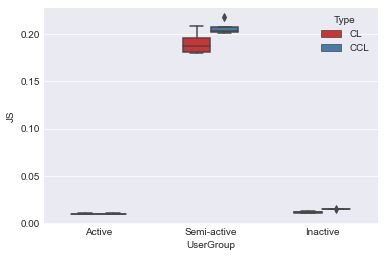

In [20]:
sns.boxplot(x="UserGroup", y="JS", hue="Type", data=heatmap_df, palette="Set1", width=0.5)
plt.savefig(f'plots/{dataset}/boxplot_JS_wSemiAct_{dataset}.pdf', bbox_inches='tight')

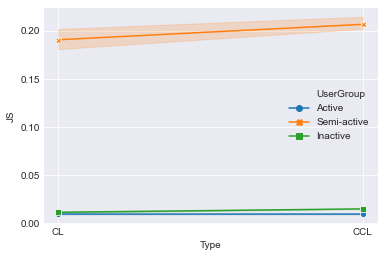

In [21]:
sns.lineplot(data=heatmap_df, x="Type", y="JS", hue="UserGroup", style="UserGroup", markers=True, dashes=False, sort=False)
plt.savefig(f'plots/{dataset}/line_JS_wSemiAct_{dataset}.pdf', bbox_inches='tight')

### Line Chart

In [6]:
line_df = pd.DataFrame(columns=['Model', 'Type', 'NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage'])

for eachline in results_df.itertuples(index=True):
  if eachline.Model not in ['MostPop', 'ItemKNN-Cosine', 'UserKNN-BM25']:
    if eachline.Type in ['CL', 'CCL']:
      line_df = line_df.append({'Model': eachline.Model,'Type': eachline.Type, 'NDCG': eachline.ndcg_ALL, 'Precision': eachline.Pre_ALL,
      'Recall': eachline.Rec_ALL, 'Novelty': eachline.Nov_ALL, 'Diversity': eachline.Dive_ALL, 'CatCov': eachline.CatCov_ALL, 'Coverage': eachline.Cov_ALL},
      ignore_index=True)

In [7]:
line_df.head()

,Model,Type,NDCG,Precision,Recall,Novelty,Diversity,CatCov,Coverage
0,NeuMF,CL,0.10578,0.09990,0.09870,2.57968,0.75987,10.94052,43.47
1,NeuMF,CCL,0.10744,0.10105,0.10131,2.58052,0.77964,13.48592,43.01
2,VAECF,CL,0.10288,0.09622,0.09463,2.37672,0.75297,10.81461,31.72
3,VAECF,CCL,0.10321,0.09661,0.09645,2.37651,0.77196,13.27237,31.72
4,WMF,CL,0.06820,0.06485,0.05972,2.08421,0.78751,10.45577,3.53


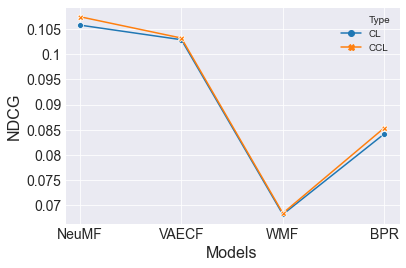

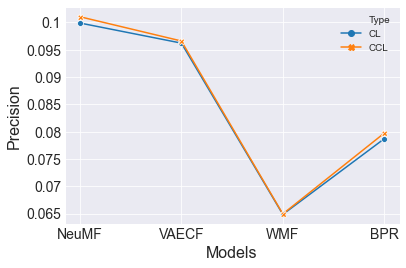

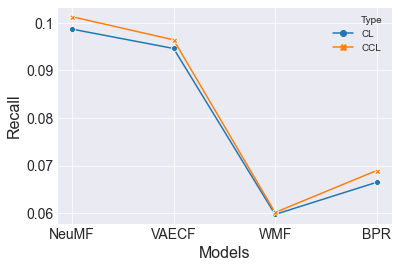

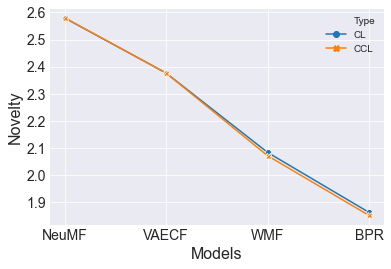

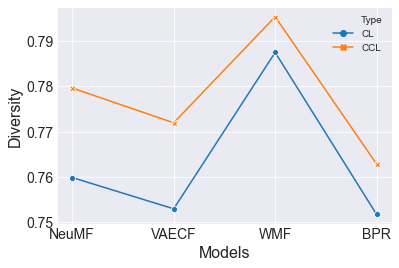

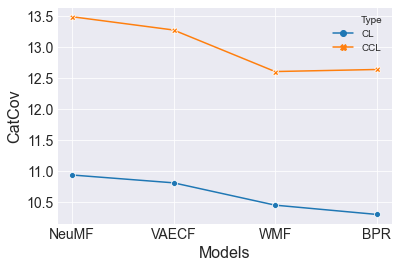

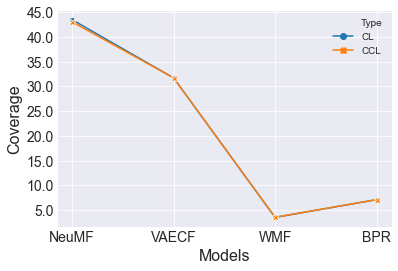

In [15]:
metrics = ['NDCG', 'Precision', 'Recall', 'Novelty', 'Diversity', 'CatCov', 'Coverage']
for metric in metrics:
    ax, fig = plt.subplots()
    p = sns.lineplot(data=line_df, x="Model", y=metric, hue="Type", style="Type", markers=True, dashes=False, sort=False)
    p.set_xticklabels(['NeuMF','VAECF','WMF','BPR'], fontsize=14)
    p.set_yticklabels(np.round(p.get_yticks(), 3), fontsize=14)
    p.set_xlabel('Models', fontsize=16)
    p.set_ylabel(metric, fontsize=16)
    plt.savefig(f'plots/{dataset}/line_{metric}_{dataset}.pdf', bbox_inches='tight')

### Radar

In [ ]:
group_results_df = results_df.groupby('Model')

In [ ]:
def radar_chart(model='BPR'):
    categories = ['Pop', 'Div', 'UnPop']
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=4)

    performance_list = []

    plt.figure(figsize=(8, 8))
    plt.subplot(111, polar=True)
    plt.tick_params(pad=23)

    for eachline in group_results_df.get_group(model).itertuples(index=True):
        if eachline.Type != "N":
            if eachline.Type == "CL":
                performance_list = [eachline.avg_JSH_pop, eachline.avg_JSH_div, eachline.avg_JSH_unpop, eachline.avg_JSH_pop]
            if eachline.Type == "CCL":
                performance_list = [eachline.avg_JSH_pop, eachline.avg_JSH_div, eachline.avg_JSH_unpop, eachline.avg_JSH_pop]
                    
            plt.plot(label_loc, performance_list, label=eachline.Type, linewidth=2)
            plt.scatter(label_loc, performance_list, s=30, zorder=10)

    # plt.title('Model comparison', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories, fontsize=16)
    # plt.set_thetagrids(frac=1.3)
    plt.legend(fontsize=18)
    plt.tight_layout()
    # plt.savefig(f"Intro_{dataset}_{type}.pdf")
    plt.savefig(f'plots/{dataset}/radar_{model}_{dataset}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
Models = ['MostPop', 'BPR', 'VAECF', 'NeuMF', 'WMF', 'PF', 'UserKNN-BM25']
for model in Models:
    radar_chart(model=model)

### Test BarChart